MCMC chain analysis
===========

In [2]:
import warnings; warnings.simplefilter('ignore')
%matplotlib inline
import numpy as np

The first thing we need to do is open the chain file.

In [3]:
raw = np.loadtxt('chain.dat');
shape = raw.size
print("Total number of elements in chain file = {}".format(shape))
    

Total number of elements in chain file = 40000


We know that the model has two parameters, so we need to reshape the chain, and find out how many steps were taken

In [4]:
save_dim = 2
num_steps = shape/(save_dim)
print("Total number of steps in chain file = {}".format(num_steps))

Total number of steps in chain file = 20000.0


Now we need to reshape the chain into something that we can use

In [5]:
chain = raw.reshape(num_steps,save_dim)
print(chain.shape)

(20000, 2)


Now we can compute some summary statistics. Maybe we can look at the mean of the parameters

In [6]:
mean_x = np.mean(chain[:,0])
mean_y = np.mean(chain[:,1])
print("Mean (x) = {0:8.3f}, Mean (y) = {1:8.3f}".format(mean_x, mean_y))

Mean (x) =    0.121, Mean (y) =    1.450


And the standard deviations


In [7]:
var_x = np.var(chain[:,0])
var_y = np.var(chain[:,1])
print("Std dev (x) = {0:8.3f}, Std dev (y) = {1:8.3f}".format(np.sqrt(var_x), np.sqrt(var_y)))

Std dev (x) =    6.495, Std dev (y) =   13.028


The true best fit value for x and y are x=0.762 and y=-0.438556, and the errors on the two should be 0.12523 and 0.56687. What has gone wrong here?

Burn-in
------

The samples are meant to represent the distribution of probabilities for the parameters. But if the chain starts in a very low probability region, the initial chain elements will not be representative of the final distribution.

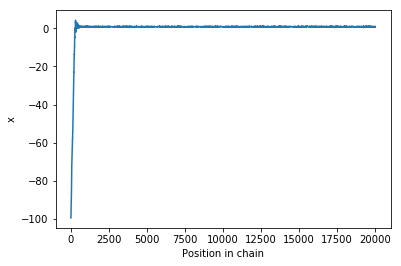

In [8]:
index = np.arange(0,num_steps)
import matplotlib.pyplot as plt
plt.plot(index,chain[:,0])
plt.xlabel('Position in chain')
plt.ylabel('x')

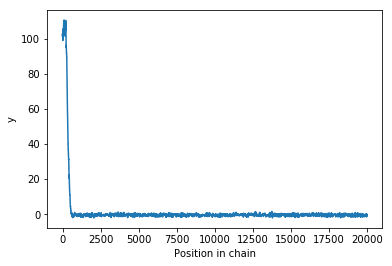

In [9]:
plt.plot(index,chain[:,1])
plt.xlabel('Position in chain')
plt.ylabel('y')

We see here that the first few hundred chain elements are composed of this 'burn-in' phase. We cut the first 1000 chain elements, and look again at the distribution.

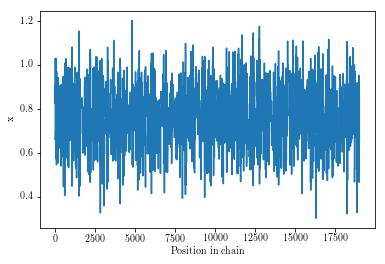

In [36]:
burn_in_index = 1000
burn_in_chain=chain[burn_in_index:,:]
burn_in_index=np.arange(0,num_steps-burn_in_index)
import matplotlib.pyplot as plt
plt.plot(burn_in_index,burn_in_chain[:,0])
plt.xlabel('Position in chain')
plt.ylabel('x')

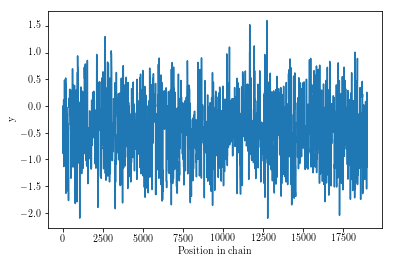

In [37]:
plt.plot(burn_in_index,burn_in_chain[:,1])
plt.xlabel('Position in chain')
plt.ylabel('y')

This random distribution around some mean indicates that we are now exploring the probability distribution peak. We now recompute the mean and variance, which should give a better estimate.

In [12]:
burn_in_mean_x = np.mean(burn_in_chain[:,0])
burn_in_mean_y = np.mean(burn_in_chain[:,1])
print("Mean (x) = {0:8.3f}, Mean (y) = {1:8.3f}".format(burn_in_mean_x, burn_in_mean_y))

Mean (x) =    0.767, Mean (y) =   -0.438


These values area much closer to the input model values of x = 0.762 and y = -0.438556,

In [13]:
burn_in_var_x = np.var(burn_in_chain[:,0])
burn_in_var_y = np.var(burn_in_chain[:,1])
print("Std dev (x) = {0:8.3f}, Std dev (y) = {1:8.3f}".format(np.sqrt(burn_in_var_x), np.sqrt(burn_in_var_y)))

Std dev (x) =    0.126, Std dev (y) =    0.550


These error values are much closer to the input values of errors, which are 0.12523 and 0.56687

# Probability distribution

The distribution of chain elements gives us the distribution of probabilities associated with each parameter. So we can histogram the chain 

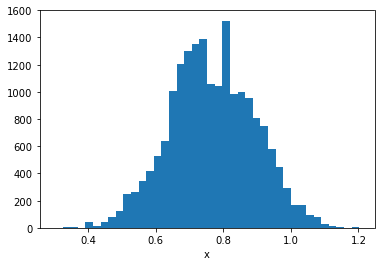

In [14]:
h_x = plt.hist(burn_in_chain[:,0],bins=40)
plt.xlabel('x')

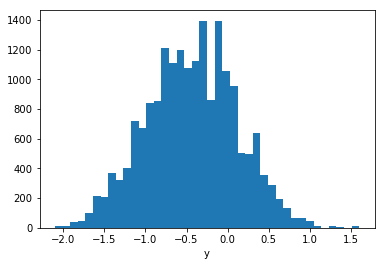

In [15]:
h_y = plt.hist(burn_in_chain[:,1],bins=40)
plt.xlabel('y')

As you can see, this histogram is slightly noisy. There are two ways to increase the accuracy of the curve, a longer chain (with more MCMC samples) or some smoothing.

In [16]:
from scipy import signal
h_new = signal.medfilt(h_x[0],5)
h_y_new = signal.medfilt(h_y[0],5)

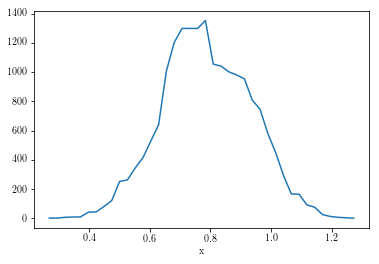

In [38]:
bins = []
len_x = len(h_x[1])
for i in range(1,len_x):
    bin_position = h_x[1][i-1]+(h_x[1][i]-h_x[1][i-1])/2.0
    bins.append(bin_position)
plt.plot(bins,h_new)
plt.xlabel('x')

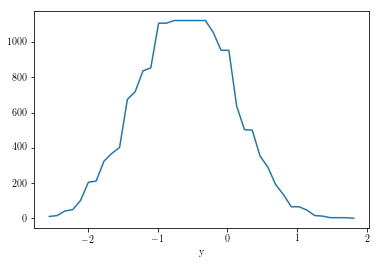

In [39]:
bins = []
len_y = len(h_y[1])
for i in range(1,len_y):
    bin_position = h_y[1][i-1]+(h_y[1][i]-h_y[1][i-1])/2.0
    bins.append(bin_position)
plt.plot(bins,h_y_new)
plt.xlabel('y')

In [40]:
raw2 = np.loadtxt('chain_long.dat');
shape2 = raw2.size
print("Total number of elements in new chain file = {}".format(shape2))
num_steps2 = shape2/(save_dim)
print("Total number of steps in new chain file = {}".format(num_steps2))

Total number of elements in new chain file = 400000
Total number of steps in new chain file = 200000.0


Alternatively, we load the new chain.

In [41]:
chain2 = raw2.reshape(num_steps2,save_dim)

Now we need to cut off the burn-in period as before.

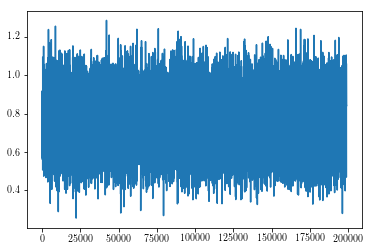

In [42]:
burn_in_cut = 1000
burn_in_chain2=chain2[burn_in_cut:,:]
burn_in_index2=np.arange(0,num_steps2-burn_in_cut)
import matplotlib.pyplot as plt
plt.plot(burn_in_index2,burn_in_chain2[:,0])

And finally plot the histograms.

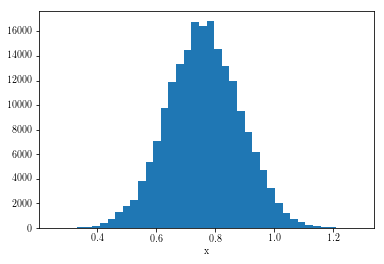

In [43]:
h_x = plt.hist(burn_in_chain2[:,0],bins=40)
plt.xlabel('x')

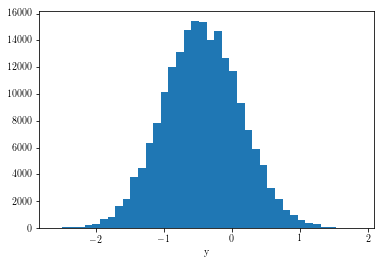

In [44]:
h_y = plt.hist(burn_in_chain2[:,1],bins=40)
plt.xlabel('y')

These histograms look a lot nicer than the previous ones.

## Convergence and Multiple Chains

Now we consider the situation where we have multiple chains, that we have run in parallel from different starting points.

In [45]:
chains = []
for ichain in range(0,4):
    raw_temp = []
    filename = 'chain_{0:1d}.dat'.format(ichain)
    raw_temp = np.loadtxt(filename);
    shape_temp = raw_temp.size
    print("Total number of elements in new chain file = {}".format(shape_temp))
    num_steps_temp = shape_temp/(save_dim)
    print("Total number of steps in new chain file = {}".format(num_steps_temp))
    chain_temp = raw_temp.reshape(num_steps_temp,save_dim)
    chains.append(chain_temp)
    
print(len(chains))

Total number of elements in new chain file = 40000
Total number of steps in new chain file = 20000.0
Total number of elements in new chain file = 40000
Total number of steps in new chain file = 20000.0
Total number of elements in new chain file = 40000
Total number of steps in new chain file = 20000.0
Total number of elements in new chain file = 40000
Total number of steps in new chain file = 20000.0
4


Now we plot them all.

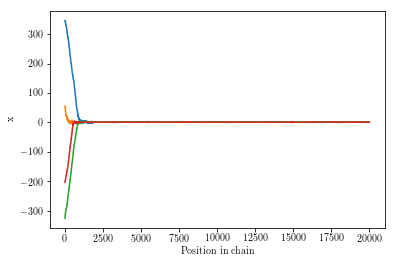

In [46]:
for ichain in range(0,4):
    n = len(chains[ichain])
    index = np.arange(0,n)
    plt.plot(index,chains[ichain][:,0])
    plt.xlabel('Position in chain')
    plt.ylabel('x')

We zoom in on the first 1000 elements.

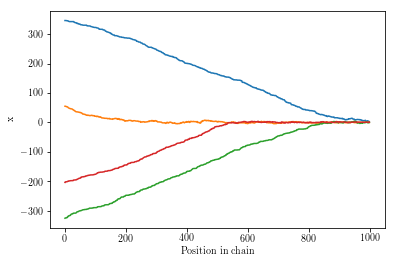

In [47]:
for ichain in range(0,4):
    index = np.arange(0,1000)
    plt.plot(index,chains[ichain][:1000,0])
    plt.xlabel('Position in chain')
    plt.ylabel('x')

As you can see, they are all burning in at different rates, depending on where they started. We will use a more conservative cut of 2000, roughly 10% of the length of the individual chain (this is normally the cut I use).

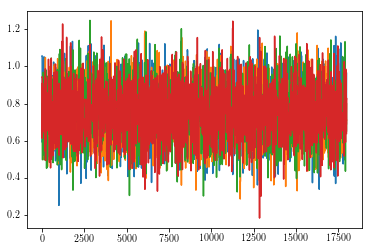

In [48]:
burn_in_chains = []
for ichain in range(0,4):
    burn_in_cut = 2000
    burn_in_chains.append(chains[ichain][burn_in_cut:,:])
    n = len(burn_in_chains[ichain])
    burn_in_index2=np.arange(0,n)
    import matplotlib.pyplot as plt
    plt.plot(burn_in_index2,burn_in_chains[ichain][:,0])

As you can see, these chains are now well mixed, and seem to be sampling the same distribution. This is a good example of _convergence_, where the chains have converged on the final probability distribution. We can evaluate convergence through the _[Gelman-Rubin statistic](https://blog.stata.com/2016/05/26/gelman-rubin-convergence-diagnostic-using-multiple-chains/)_

First we need to compute the average internal chain variance.

In [49]:
W_sum = 0.0
for ichain in range(0,4):
    W_sum += np.var(burn_in_chains[ichain][:,0])
    
W_sum /= 4
print(W_sum)

0.0152251170257


Now we need to compute the between chain variance

In [50]:
means_chains = []
for ichain in range(0,4):
    means_chains.append(np.mean(burn_in_chains[ichain][:,0]))
    
overall_mean = sum(means_chains)/4.0
print(overall_mean)
B_sum = 0.0
for ichain in range(0,4):
    B_sum += (means_chains[ichain]-overall_mean)**2
    
B_sum *= np.float(len(burn_in_chains[0]))/(4.0-1.0)
print(B_sum)

0.759641724397
0.14693784661


Now we compute the ratio of this with respect to the internal chain variance.

In [51]:
N = np.float(len(burn_in_chains[0]))
R = ((N-1)/N)*W_sum + (1.0/N)*B_sum
R /= W_sum
R -= 1
print(R)

0.000480611994863


We see that this number is very close to zero, implying very good _mixing_ between the chains, and so convergence.

## Two-dimensional distributions 

To show the two-dimensional probability distributions, I am going to the use the _[ChainConsumer](https://samreay.github.io/ChainConsumer/)_ package

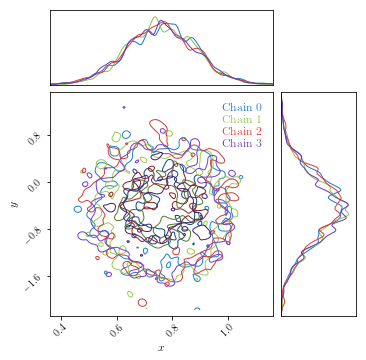

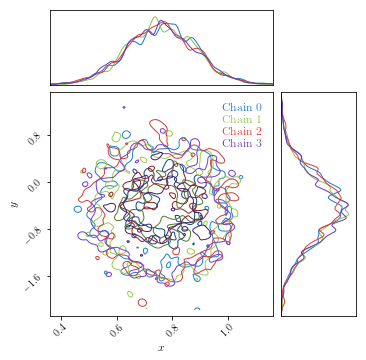

In [52]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
for ichain in range(0,4):
    c.add_chain(burn_in_chains[ichain], parameters=["$x$", "$y$"])

c.plotter.plot(figsize="column")

We see that the two-dimensioanl constraints are quite noisy, because the chains are relatively short. But, now that we have cut off the burn-in section, and we are sure that they are exploring the same underlying distributions, we can concatenate the chains, to give one long chain.

In [53]:
long_chain = burn_in_chains[0]
for ichain in range(1,4):
    new_chain = burn_in_chains[ichain]
    long_chain = np.concatenate((long_chain,new_chain))

print(long_chain.shape)

(72000, 2)


And now we plot again

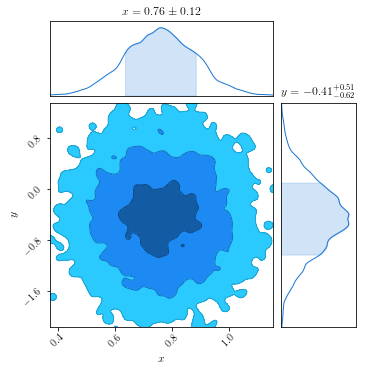

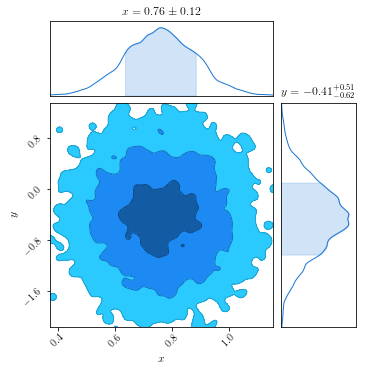

In [54]:
c = ChainConsumer()
c.add_chain(long_chain, parameters=["$x$", "$y$"])
c.plotter.plot(figsize="column")

Finally we comapre to our very long chain from earlier

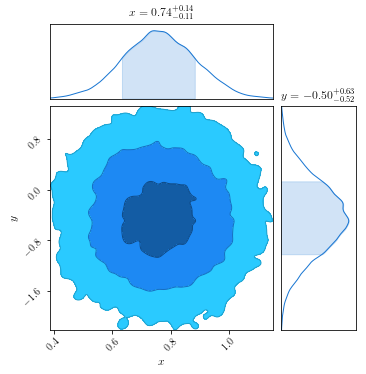

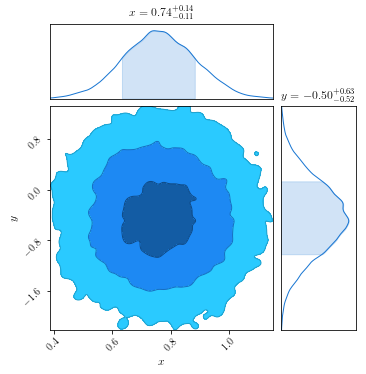

In [55]:
c = ChainConsumer()
c.add_chain(burn_in_chain2,parameters=["$x$","$y$"])
c.plotter.plot(figsize="column")

We can also ask ChainConsumer to create a latex table of the credible intervals

In [56]:
table = c.analysis.get_latex_table(caption="Results for the tested models", label="tab:example")
print(table)

\begin{table}
    \centering
    \caption{Results for the tested models}
    \label{tab:example}
    \begin{tabular}{ccc}
        \hline
		Model & $x$ & $y$ \\ 
		\hline
		Chain 0 & $0.74^{+0.14}_{-0.11}$ & $-0.50^{+0.63}_{-0.52}$ \\ 
		\hline
    \end{tabular}
\end{table}
